First I will will create a model from which the data is produced. I assume that we have an $n \times n$ grid of numbers and a period of $N$ days. The refernce for the model used can be found on https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html .

In [1]:
import sys
import seaborn as sbn
import pandas as pd
import pyro 
import pyro.distributions as dist
import numpy as np 
import torch
from pyro.infer import MCMC, NUTS
sys.path.append('../')

from helper_functions import utils


Here we specify the adjacency matrix used to generate the data

In [3]:
rows = 20
cols = 20
alpha = 0.5

W = utils.make_grid_adjacency_matrix(rows, cols)
D_inv = np.diag(1/np.sum(W, 1))
D = np.diag(np.sum(W,1))
B = D_inv @ W
tau = 2
alpha = 0.5
prec_mat =  tau*D@(np.identity(rows * cols) - alpha * B)
np.linalg.inv(prec_mat)

array([[2.74737730e-01, 4.94754598e-02, 9.01151269e-03, ...,
        3.06906769e-22, 9.06619310e-23, 4.53309655e-23],
       [4.94754598e-02, 1.84798323e-01, 3.31074464e-02, ...,
        5.51353598e-22, 1.70913872e-22, 9.06619310e-23],
       [9.01151269e-03, 3.31074464e-02, 1.81794090e-01, ...,
        1.70864476e-21, 5.51353598e-22, 3.06906769e-22],
       ...,
       [3.06906769e-22, 5.51353598e-22, 1.70864476e-21, ...,
        1.81794090e-01, 3.31074464e-02, 9.01151269e-03],
       [9.06619310e-23, 1.70913872e-22, 5.51353598e-22, ...,
        3.31074464e-02, 1.84798323e-01, 4.94754598e-02],
       [4.53309655e-23, 9.06619310e-23, 3.06906769e-22, ...,
        9.01151269e-03, 4.94754598e-02, 2.74737730e-01]])

In [3]:
torch.eye(10)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [18]:
## T
rows = 15
cols = 15
num_predictors = 2
var_beta = 1
noise_var = 0.025
def data_generation(rows, cols, num_predictors, var_beta, noise_var): 
    """ 
    row and col denote the rows and columns of the grid
    num_predictors indicates how many betas are used in the 
    log normal poisson model
    """
    
    # Dictionary to keep the parameters in store
    params = {}
    
    n = rows * cols
    
    beta_dist = dist.Normal(torch.zeros(num_predictors + 1), var_beta)
    betas = pyro.sample('betas',beta_dist)
    params['betas'] = betas
    
    # Spatial correlation
    W = torch.Tensor(utils.make_grid_adjacency_matrix(rows, cols))
    D_inv = torch.diag(1/torch.sum(W,1))
    D = torch.diag(torch.sum(W, 1))
    B = D_inv @ W
    alpha = pyro.sample('alpha', dist.Uniform(0,1))
    tau = pyro.sample('tau', dist.Gamma(2,2))
    prec_mat = tau * D @ (torch.eye(n) - alpha * B)
    
    params['alpha'] = alpha
    params['tau'] = tau
    
    phi_dist = dist.MultivariateNormal(torch.zeros(n), precision_matrix = prec_mat)
    phi = pyro.sample('phi', phi_dist)
    params['phi'] = phi


    with pyro.plate('gen_data_plate', rows * cols): 
        noise = pyro.sample('noise', dist.Normal(0,noise_var))
        with pyro.plate('gen_predictor_plate', num_predictors):
            predictors = pyro.sample('predictors', dist.Uniform(-1,1))
            
    ones = torch.unsqueeze(torch.ones(rows * cols), 0)
    predictors = torch.cat((predictors, ones), 0)
    params['predictors'] = predictors
    log_theta =  predictors.T @ betas + noise + phi
    theta = torch.exp(log_theta)
    accidents = pyro.sample('accidents', dist.Poisson(theta))
    params['accidents'] = accidents

    return params
    
    
    
params = data_generation(rows,cols, num_predictors, var_beta, noise_var)
    

In [19]:
params['predictors'].shape

torch.Size([3, 225])

As we can see in the plot below we do see that there seems to be some form of spatial correlation in that there are clusters of points with higher density

tensor(0.1121)


<AxesSubplot:>

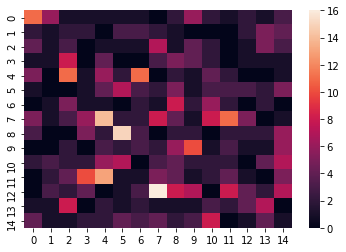

In [20]:
grid = np.reshape(params['accidents'].numpy(),(rows,cols))
print(params['alpha'])
sbn.heatmap(grid)

In [21]:
W = torch.Tensor(utils.make_grid_adjacency_matrix(rows, cols))
D_inv = torch.diag(1/torch.sum(W,1))
D = torch.diag(torch.sum(W, 1))
B = D_inv @ W
def model(accidents, predictors):
    n = rows * cols
    
    beta_dist = dist.Normal(torch.zeros(num_predictors + 1), var_beta)
    betas = pyro.sample('betas',beta_dist)
    
    # Spatial correlation
    alpha = pyro.sample('alpha', dist.Uniform(0.8,1))
    tau = pyro.sample('tau', dist.Gamma(2,2))
    prec_mat = tau * D @ (torch.eye(n) - alpha * B)

    phi_dist = dist.MultivariateNormal(torch.zeros(n), precision_matrix = prec_mat)
    phi = pyro.sample('phi', phi_dist)
    
    with pyro.plate('gen_data_plate', rows * cols): 
        noise = pyro.sample('noise', dist.Normal(0,noise_var))
            
    log_theta =  predictors @ betas + noise + phi
    theta = torch.exp(log_theta)
    pyro.sample('accidents', dist.Poisson(theta), obs = accidents)


In [22]:
nuts_kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples = 10000, warmup_steps = 1000)
mcmc.run(params['accidents'], params['predictors'].T)


Sample: 100%|██████████| 11000/11000 [18:06, 10.12it/s, step size=2.67e-01, acc. prob=0.848]


In [24]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

for site, values in summary(hmc_samples).items():
    print("site: {}".format(site))
    print(values, "\n")

site: betas
       mean       std        5%       25%       50%       75%       95%
0 -0.192864  0.082753 -0.327374 -0.249098 -0.193866 -0.137244 -0.055506
1 -1.351493  0.095334 -1.509377 -1.415434 -1.351204 -1.287573 -1.195462
2  0.661061  0.094567  0.519320  0.610254  0.666484  0.719334  0.798773 

site: alpha
       mean      std        5%       25%       50%       75%       95%
0  0.865907  0.04763  0.805121  0.825881  0.856999  0.898153  0.956343 

site: tau
       mean       std        5%       25%       50%       75%       95%
0  2.983373  0.783185  1.905216  2.416387  2.877721  3.438708  4.437792 

site: phi
         mean       std        5%       25%       50%       75%       95%
0    0.256603  0.278760 -0.209846  0.073857  0.257319  0.442840  0.707216
1   -0.090121  0.285243 -0.564693 -0.277498 -0.086750  0.105755  0.362700
2   -0.160901  0.375364 -0.774972 -0.413670 -0.159338  0.090220  0.448939
3   -0.372223  0.342538 -0.944676 -0.596937 -0.365581 -0.140121  0.175798
4   -0

In [25]:
for key in params.keys(): 
    print(key)
    print(params[key])

betas
tensor([-0.2059, -1.3564,  0.6777])
alpha
tensor(0.1121)
tau
tensor(2.3142)
phi
tensor([ 0.5901, -0.3430,  0.1099, -0.6282, -0.0218,  0.3656,  0.4804, -0.5921,
        -0.0581,  0.4385, -0.4251, -0.5162, -0.3288,  0.5274, -0.3447, -0.3570,
         0.0088, -0.5025, -0.0061, -0.1532,  0.1138, -0.0172,  0.6078, -0.5307,
        -0.1846, -0.1078, -0.0354,  0.0309,  0.2951, -0.4887, -0.0019,  0.6475,
         0.1099, -0.1359, -0.7193, -0.2853,  0.5342,  0.7988,  0.0583, -0.2783,
         0.2530, -0.6635, -0.6705,  0.0180, -0.2903, -0.0175,  0.5183,  0.2113,
        -0.3722,  0.0689, -0.1745,  0.0098, -0.2392,  0.2353, -0.1356,  0.0952,
        -0.1710, -0.0621, -0.0034, -0.2485,  0.0211, -0.1210,  0.3807, -0.4074,
         0.4220, -0.1291,  0.5278, -0.1193, -0.5461, -0.6699,  0.5685,  0.1677,
         0.0155,  0.1533,  0.3329, -0.3898,  0.1372, -0.1170,  0.0742, -0.4704,
        -0.0079, -0.2003,  0.0586,  0.2609, -0.0598,  0.1954,  0.0789,  0.5840,
         0.5099,  0.1693, -0.0938,

Now, I will implement the same model but I will be using the sparse version. Ideally, I will be able to get the same values as I did before but in a simpler way. 

In [30]:
rows = 20
cols = 20
W = torch.tensor(utils.make_grid_adjacency_matrix(rows, cols), dtype=torch.float)
W_sparse = torch.tensor(utils.make_sparse_representation_matrix(rows,cols))
D_sparse = torch.sum(W,1, dtype=torch.float)
D_invsq = torch.diag(1/torch.sqrt(D_sparse))
D = torch.diag(torch.sum(W, 1))
B = D_invsq @ W @ D_invsq
eigenvalues, _ = torch.eig(B)
eigen = eigenvalues[:,0]


In [31]:
def fast_model(accidents,predictors):
    n = rows * cols
    
    beta_dist = dist.Normal(torch.zeros(num_predictors + 1), var_beta)
    betas = pyro.sample('betas',beta_dist)
    
    # Spatial correlation
    alpha = pyro.sample('alpha', dist.Uniform(0.8,1))
    tau = pyro.sample('tau', dist.Gamma(2,2))

    phi_dist = utils.FastCar(alpha, tau, n, eigen, D_sparse, W_sparse)
    phi = pyro.sample('phi', phi_dist)
    
    with pyro.plate('gen_data_plate', rows * cols): 
        noise = pyro.sample('noise', dist.Normal(0,noise_var))
            
    log_theta =  predictors @ betas + noise + phi
    theta = torch.exp(log_theta)
    pyro.sample('accidents', dist.Poisson(theta), obs = accidents)

In [32]:
nuts_kernel = NUTS(fast_model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples = 6000, warmup_steps = 1000)
mcmc.run(params['accidents'], params['predictors'].T)


Sample: 100%|██████████| 7000/7000 [3:14:39,  1.67s/it, step size=3.98e-08, acc. prob=0.719]


In [15]:

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

for site, values in summary(hmc_samples).items():
    print("site: {}".format(site))
    print(values, "\n")

site: betas
       mean       std        5%       25%       50%       75%       95%
0 -0.727254  0.000004 -0.727257 -0.727256 -0.727255 -0.727254 -0.727243
1  1.303648  0.000005  1.303642  1.303643  1.303646  1.303652  1.303655
2 -0.648657  0.000003 -0.648660 -0.648659 -0.648658 -0.648657 -0.648650 

site: alpha
       mean           std        5%       25%       50%       75%       95%
0  0.845388  1.551817e-07  0.845388  0.845388  0.845388  0.845388  0.845388 

site: tau
            mean            std            5%           25%            50%  \
0  232500.421875  173358.015625  11650.692871  66903.462891  212120.835938   

             75%           95%  
0  384647.515625  522658.24375   

site: phi
        mean       std        5%       25%       50%       75%       95%
0   0.578108  0.000004  0.578099  0.578105  0.578109  0.578110  0.578111
1  -0.081452  0.000003 -0.081455 -0.081453 -0.081452 -0.081450 -0.081448
2   1.664188  0.000003  1.664181  1.664187  1.664190  1.664191  1.66